In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Concatenate, Multiply, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import numpy as np
import os
import cv2
import math

# Constants
shape_r = 240
shape_c = 320
shape_r_gt = 30
shape_c_gt = 40
prior_size = (int(shape_r_gt / 10), int(shape_c_gt / 10))

# Define MLNet feature extractor
def mlnet_feature_extractor(img_rows=240, img_cols=320):
    input_ml_net = Input(shape=(img_rows, img_cols, 3))

    # Conv Blocks
    base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(img_rows, img_cols, 3))

    conv1_1 = base_model.get_layer("block1_conv1")(input_ml_net)
    conv1_2 = base_model.get_layer("block1_conv2")(conv1_1)
    conv1_pool = base_model.get_layer("block1_pool")(conv1_2)

    conv2_1 = base_model.get_layer("block2_conv1")(conv1_pool)
    conv2_2 = base_model.get_layer("block2_conv2")(conv2_1)
    conv2_pool = base_model.get_layer("block2_pool")(conv2_2)

    conv3_1 = base_model.get_layer("block3_conv1")(conv2_pool)
    conv3_2 = base_model.get_layer("block3_conv2")(conv3_1)
    conv3_3 = base_model.get_layer("block3_conv3")(conv3_2)
    conv3_pool = base_model.get_layer("block3_pool")(conv3_3)

    conv4_1 = base_model.get_layer("block4_conv1")(conv3_pool)
    conv4_2 = base_model.get_layer("block4_conv2")(conv4_1)
    conv4_3 = base_model.get_layer("block4_conv3")(conv4_2)
    conv4_pool = tf.keras.layers.MaxPooling2D((2, 2), strides=(1, 1), padding='same')(conv4_3)  # Custom adjustment

    conv5_1 = base_model.get_layer("block5_conv1")(conv4_pool)
    conv5_2 = base_model.get_layer("block5_conv2")(conv5_1)
    conv5_3 = base_model.get_layer("block5_conv3")(conv5_2)

    feature_extractor = Model(inputs=input_ml_net, outputs=[conv3_pool, conv4_pool, conv5_3])
    return feature_extractor

feature_extractor = mlnet_feature_extractor()


# Initialize layers
int_conv_layer = Conv2D(
    filters=64,
    kernel_size=(3, 3),
    activation='relu',
    padding='same',
    kernel_initializer='glorot_normal',
    name="int_conv"
)

pre_final_conv_layer = Conv2D(
    filters=1,
    kernel_size=(1, 1),
    activation='relu',
    kernel_initializer='glorot_normal',
    name="pre_final_conv"
)

prior = tf.Variable(
    initial_value=tf.ones([1, prior_size[0], prior_size[1], 1]),
    trainable=True,
    dtype=tf.float32,
    name="prior"
)

# Combine everything into one full model
def create_full_model(img_rows=240, img_cols=320, shape_r_gt=30, shape_c_gt=40):
    # Feature extractor
    input_layer = feature_extractor.input
    conv3_pool, conv4_pool, conv5_3 = feature_extractor.output

    # Concatenate feature maps
    concatenated = Concatenate(axis=-1)([conv3_pool, conv4_pool, conv5_3])

    # Dropout for regularization
    dropout_output = Dropout(0.5)(concatenated)

    # Intermediate convolutional layer
    int_conv_output = int_conv_layer(dropout_output)

    # Final convolutional layer
    pre_final_conv_output = pre_final_conv_layer(int_conv_output)

    # Upsample prior to match target shape
    prior_upsampled = tf.image.resize(prior, [shape_r_gt, shape_c_gt])

    # Multiply with prior to get the final saliency map
    final_output = Multiply()([pre_final_conv_output, prior_upsampled])

    # Create the model
    full_model = Model(inputs=input_layer, outputs=final_output)
    return full_model

# Create the model
full_model = create_full_model()
full_model.summary()


def mod_mse_loss(y_true, y_pred, prior, shape_r_gt, shape_c_gt):
    # Normalize the predicted output
    y_pred_max = tf.reduce_max(y_pred, axis=[1, 2], keepdims=True)
    y_pred_normalized = y_pred / (y_pred_max + 1e-6)

    # Regularization term for the prior map
    prior_size = tf.cast(tf.shape(prior)[1:3], tf.float32)
    reg = (1.0 / (prior_size[0] * prior_size[1])) * tf.reduce_sum((1 - prior) ** 2)

    # Modified MSE loss
    loss = tf.reduce_mean(((y_pred_normalized - y_true) ** 2) / (1 - y_true + 0.1)) + reg
    return loss



# Compile the model
full_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=lambda y_true, y_pred: mod_mse_loss(y_true, y_pred, prior, shape_r_gt, shape_c_gt)
)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 240, 320, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 240, 320, 64)   │          1,792 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 240, 320, 64)   │         36,928 │ block1_conv1[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 120, 160, 64)   │              0 │ block1_conv2[1][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 120, 160, 128)  │         73,856 │ block1_pool[1][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 120, 160, 128)  │        147,584 │ block2_conv1[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 60, 80, 128)    │              0 │ block2_conv2[1][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 60, 80, 256)    │        295,168 │ block2_pool[1][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 60, 80, 256)    │        590,080 │ block3_conv1[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 60, 80, 256)    │        590,080 │ block3_conv2[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 30, 40, 256)    │              0 │ block3_conv3[1][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 30, 40, 512)    │      1,180,160 │ block3_pool[1][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 30, 40, 512)    │      2,359,808 │ block4_conv1[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 30, 40, 512)    │      2,359,808 │ block4_conv2[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 30, 40, 512)    │              0 │ block4_conv3[1][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 30, 40, 512)    │      2,359,808 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 30, 40, 512)    │      2,359,808 │ block5_conv1[1][0]     │
├──────────────────────

 Total params: 15,452,097 (58.95 MB)

 Trainable params: 15,452,097 (58.95 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


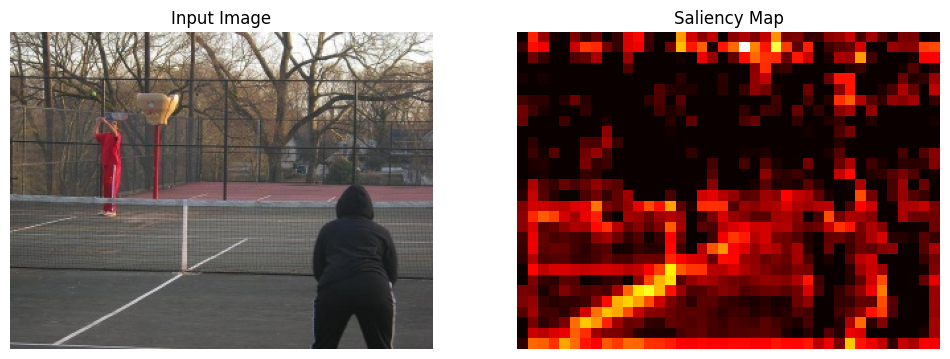

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

# Load preprocessed image function
def load_preprocessed_image(image_path):
    """
    Load a preprocessed image for the MLNet model.
    Assumes the image is already resized and normalized.
    """
    # Load the image as a numpy array
    image = tf.keras.utils.load_img(image_path, target_size=(240, 320))  # Ensure correct size
    image = tf.keras.utils.img_to_array(image) / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Visualize output function
def visualize_output(input_image, saliency_map):
    """
    Visualize the input image and the saliency map.
    """
    plt.figure(figsize=(12, 6))

    # Input image
    plt.subplot(1, 2, 1)
    plt.imshow(input_image[0])  # Remove batch dimension
    plt.title("Input Image")
    plt.axis("off")

    # Saliency map
    plt.subplot(1, 2, 2)
    plt.imshow(tf.squeeze(saliency_map), cmap='hot')  # Remove batch and channel dimensions
    plt.title("Saliency Map")
    plt.axis("off")

    plt.show()

# Path to an example image
example_image_path = "/content/drive/MyDrive/BU/preprocessed_images/train_images/COCO_train2014_000000000419.jpg"

# Load and preprocess the image
input_image = load_preprocessed_image(example_image_path)

# Extract features using the feature extractor
saliency_map  = full_model.predict(input_image)  # Extract conv3_pool, conv4_pool, conv5_3



# Visualize the input image and saliency map
visualize_output(input_image, saliency_map)


In [ ]:
import os

# 디렉토리 내 이미지 파일 개수를 확인하는 함수
def count_images_in_dir(directory):
    """
    디렉토리 내 이미지 파일 개수를 계산
    :param directory: 이미지 파일이 저장된 디렉토리 경로
    :return: 이미지 파일 개수
    """
    # 지원되는 이미지 파일 확장자
    supported_extensions = ('.png', '.jpg', '.jpeg')
    # 확장자 필터링 후 파일 리스트
    files = [f for f in os.listdir(directory) if f.endswith(supported_extensions)]
    return len(files)

# 디렉토리 경로 설정
processed_train_images_dir = '/content/drive/MyDrive/BU/preprocessed_images/train_images/'
processed_train_maps_dir = '/content/drive/MyDrive/BU/preprocessed_images/train_maps/'
processed_val_images_dir = '/content/drive/MyDrive/BU/preprocessed_images/val_images/'
processed_val_maps_dir = '/content/drive/MyDrive/BU/preprocessed_images/val_maps/'

# 각 디렉토리의 이미지 파일 개수 출력
train_images_count = count_images_in_dir(processed_train_images_dir)
train_maps_count = count_images_in_dir(processed_train_maps_dir)
val_images_count = count_images_in_dir(processed_val_images_dir)
val_maps_count = count_images_in_dir(processed_val_maps_dir)

print(f"훈련 이미지 개수: {train_images_count}")
print(f"훈련 맵 개수: {train_maps_count}")
print(f"검증 이미지 개수: {val_images_count}")
print(f"검증 맵 개수: {val_maps_count}")


훈련 이미지 개수: 10000
훈련 맵 개수: 10000
검증 이미지 개수: 5000
검증 맵 개수: 5000


In [ ]:
# Constants
b_s = 16  # batch size
nb_epoch = 20  # number of epochs

# Data Generator
def data_generator(images_dir, maps_dir, batch_size):
    """
    배치 단위로 데이터 로드 (전처리된 데이터 사용).
    :param images_dir: 이미지 파일 경로
    :param maps_dir: 맵 파일 경로
    :param batch_size: 배치 크기
    :return: 배치 단위로 데이터를 반환하는 제너레이터
    """
    image_files = [f for f in os.listdir(images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    map_files = [f for f in os.listdir(maps_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    image_files.sort()
    map_files.sort()

    while True:  # 무한 반복
        for i in range(0, len(image_files), batch_size):
            batch_images = []
            batch_maps = []

            for j in range(i, min(i + batch_size, len(image_files))):
                # 이미지 및 맵 파일 경로
                img_path = os.path.join(images_dir, image_files[j])
                map_path = os.path.join(maps_dir, map_files[j])

                # Load images using cv2.imread
                img = cv2.imread(img_path)  # 전처리된 이미지를 로드
                sal_map = cv2.imread(map_path, cv2.IMREAD_GRAYSCALE)  # 전처리된 맵을 로드

                # Ensure images are loaded correctly
                if img is None:
                    print(f"Warning: Could not read image {img_path}")
                    continue
                if sal_map is None:
                    print(f"Warning: Could not read map {map_path}")
                    continue

                # Normalize images and maps
                img = img / 255.0
                sal_map = sal_map / 255.0

                batch_images.append(img)
                batch_maps.append(sal_map)

            # Yield data only if both batch_images and batch_maps are not empty
            if len(batch_images) == batch_size:
                yield (np.array(batch_images, dtype=np.float32), np.array(batch_maps, dtype=np.float32))

# Load Train and Validation Generators
train_generator = data_generator(processed_train_images_dir, processed_train_maps_dir, b_s)
val_generator = data_generator(processed_val_images_dir, processed_val_maps_dir, b_s)

# 데이터 크기 확인
num_train_samples = len(os.listdir(processed_train_images_dir))
num_val_samples = len(os.listdir(processed_val_images_dir))
steps_per_epoch = math.ceil(num_train_samples / b_s)


steps_per_epoch = math.ceil(num_train_samples / b_s)
validation_steps = math.ceil(num_val_samples / b_s)

print(f"Number of training samples: {num_train_samples}")
print(f"Number of validation samples: {num_val_samples}")

Number of training samples: 10000
Number of validation samples: 5000


In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    filepath='weights.mlnet.{epoch:02d}-{val_loss:.4f}.keras',
    monitor='val_loss',
    save_best_only=True
)

# Train Model
print("Starting model training...")
history = full_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=nb_epoch,
    callbacks=[early_stopping, model_checkpoint]
)

print("Training complete!")

Starting model training...
Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.0269

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:     loss=lambda y_true, y_pred: mod_mse_loss(y_true, y_pred, prior, shape_r_gt, shape_c_gt)

  return {key: serialize_keras_object(value) for key, value in obj.items()}


625/625 ━━━━━━━━━━━━━━━━━━━━ 3626s 6s/step - loss: 0.0269 - val_loss: 0.0188
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 333s 533ms/step - loss: 0.0170 - val_loss: 0.0169
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 337s 539ms/step - loss: 0.0150 - val_loss: 0.0171
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 337s 539ms/step - loss: 0.0134 - val_loss: 0.0165
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 336s 537ms/step - loss: 0.0122 - val_loss: 0.0165
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 332s 531ms/step - loss: 0.0111 - val_loss: 0.0166
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 331s 530ms/step - loss: 0.0104 - val_loss: 0.0162
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 330s 527ms/step - loss: 0.0097 - val_loss: 0.0167
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 330s 528ms/step - loss: 0.0092 - val_loss: 0.0160
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 329s 527ms/step - loss: 0.0085 - val_loss: 0.0166
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 329s 526ms/step - loss: 0.0082 - val_loss: 0.0162
Epoch 12/20
625/625 ━

In [ ]:
# 7. Save the Model
print("Saving the model...")

# Define model save paths
model_save_path_keras = "/content/drive/MyDrive/BU/saved_model3/ml_net_model.keras"  # For .keras format (recommended)
model_save_path_h5 = "/content/drive/MyDrive/BU/saved_model3/ml_net_model.h5"        # For .h5 format
int_conv_layer_path = '/content/drive/MyDrive/BU/saved_model3/int_conv_weights.weights.h5'
pre_final_conv_save_path = '/content/drive/MyDrive/BU/saved_model3/pre_final_conv_weights.weights.h5'
prior_save_path = '/content/drive/MyDrive/BU/saved_model3/prior_weights.npy'     # Path to save prior weights

# Save the entire model in .keras format (recommended)
feature_extractor.save(model_save_path_keras)

# Save the model in .h5 format
feature_extractor.save(model_save_path_h5)

# Save prior weights
np.save(prior_save_path, prior.numpy())
print(f"Prior weights saved to {prior_save_path}")

# Save pre_final_conv_layer weights
pre_final_conv_model = tf.keras.Sequential([pre_final_conv_layer])
pre_final_conv_model.save_weights(pre_final_conv_save_path)
print(f"Pre_final_conv_layer weights saved to {pre_final_conv_save_path}")

int_conv_model = tf.keras.Sequential([int_conv_layer])
int_conv_model.save_weights(int_conv_layer_path)
print(f"Intermediate_conv_layer weights saved to {int_conv_layer_path}")

print(f"Model and weights saved successfully!")

Saving the model...


Prior weights saved to /content/drive/MyDrive/BU/saved_model3/prior_weights.npy
Pre_final_conv_layer weights saved to /content/drive/MyDrive/BU/saved_model3/pre_final_conv_weights.weights.h5
Intermediate_conv_layer weights saved to /content/drive/MyDrive/BU/saved_model3/int_conv_weights.weights.h5
Model and weights saved successfully!


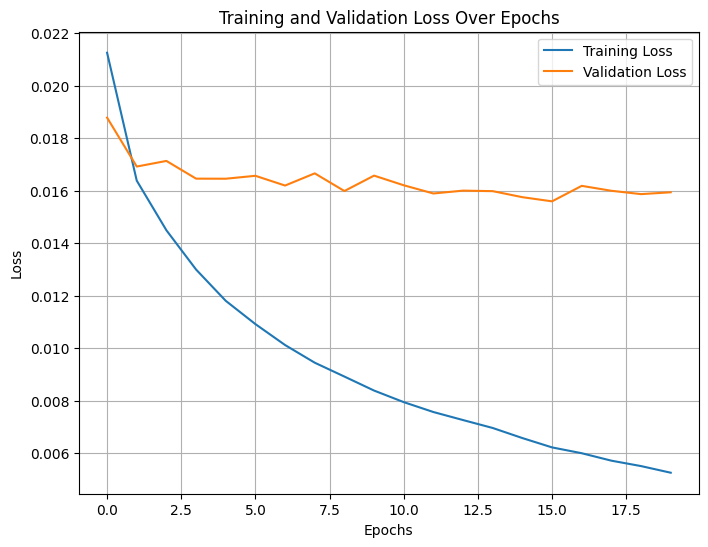

In [ ]:
import matplotlib.pyplot as plt

# Visualize training process
def plot_training_history(history):
    """
    Plots the training and validation loss from the training history.
    """
    # Extract loss and validation loss
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot the training and validation loss
    plt.figure(figsize=(8, 6))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

# Call the function to plot the training history
plot_training_history(history)


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt

# Paths to saved model and weights
model_path = "/content/drive/MyDrive/BU/saved_model3/ml_net_model.h5"
int_conv_path = '/content/drive/MyDrive/BU/saved_model3/int_conv.weights.h5'
pre_final_conv_path = '/content/drive/MyDrive/BU/saved_model3/pre_final_conv.weights.h5'
prior_path = '/content/drive/MyDrive/BU/saved_model3/prior_weights.npy'


# Load model
mlnet = load_model(model_path, compile=False)


prior = tf.Variable(
    initial_value=np.load(prior_path),
    trainable=False,
    name="prior",
    dtype=tf.float32,
)


pre_final_conv_layer = Conv2D(
    filters=1,
    kernel_size=(1, 1),
    activation="relu",
    kernel_initializer="glorot_normal",
    name="pre_final_conv"
)
pre_final_conv_model = tf.keras.Sequential([pre_final_conv_layer])
pre_final_conv_model.build(input_shape=(None, 30, 40, 64))
pre_final_conv_model.load_weights(pre_final_conv_path)


int_conv_layer = Conv2D(
    filters=64,
    kernel_size=(3, 3),
    activation='relu',
    padding='same',
    kernel_initializer='glorot_normal',
    name="int_conv"
)
int_conv_model = tf.keras.Sequential([int_conv_layer])
int_conv_model.build(input_shape=(None, 30, 40, 1280))
int_conv_model.load_weights(int_conv_path)

shape_r_gt, shape_c_gt = 30, 40
'''


image_path = "/content/drive/MyDrive/BU/preprocessed_images/train_images/COCO_train2014_000000000419.jpg"
ground_truth_path = "/content/drive/MyDrive/BU/preprocessed_images/train_maps/COCO_train2014_000000000419.png"

# Load and preprocess image
def preprocess_image(image_path, target_size=(240, 320)):
    """
    Load and preprocess an image for the model.
    """
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
    return np.expand_dims(img_array, axis=0)  # Add batch dimension

# Load and preprocess ground truth
def preprocess_ground_truth(gt_path, target_size=(30, 40)):
    """
    Load and preprocess a ground truth saliency map.
    """
    gt = load_img(gt_path, color_mode="grayscale", target_size=target_size)
    gt_array = img_to_array(gt) / 255.0  # Normalize to [0, 1]
    return gt_array


# Compute final output (saliency map)
def compute_final_output(conv3_pool, conv4_pool, conv5_3, shape_r_gt, shape_c_gt):

    concatenated = Concatenate(axis=-1)([conv3_pool, conv4_pool, conv5_3])
    dropout_output = Dropout(0.5)(concatenated)
    int_conv_output = int_conv_model(dropout_output)
    pre_final_conv_output = pre_final_conv_model(int_conv_output)
    prior_upsampled = tf.image.resize(prior, [shape_r_gt, shape_c_gt])
    saliency_map = tf.keras.layers.Multiply()([pre_final_conv_output, prior_upsampled])
    return saliency_map


# Overlay Saliency Map on Input Image
def overlay_saliency_map(input_image, saliency_map, alpha=0.5):

    # Remove batch dimension and normalize saliency map
    input_image = input_image[0]  # Shape: (height, width, 3)
    saliency_map = tf.squeeze(saliency_map)  # Remove batch and channel dimensions
    saliency_map = tf.image.resize(saliency_map[..., tf.newaxis], input_image.shape[:2])  # Resize to match input image
    saliency_map = tf.squeeze(saliency_map).numpy()  # Convert to numpy for overlaying
    saliency_map = (saliency_map - np.min(saliency_map)) / (np.max(saliency_map) - np.min(saliency_map))  # Normalize to [0, 1]

    # Overlay saliency map on input image
    overlay = input_image * (1 - alpha) + plt.cm.jet(saliency_map)[..., :3] * alpha  # Use 'jet' colormap
    return np.clip(overlay, 0, 1)  # Ensure values are within [0, 1]


# Visualize the overlay
def visualize_results_with_overlay(image, saliency_map, ground_truth):
    """
    Visualizes the input image, saliency map, overlayed image, and ground truth.
    """
    # Generate overlayed image
    overlayed_image = overlay_saliency_map(image, saliency_map)

    plt.figure(figsize=(24, 6))

    # Input image
    plt.subplot(1, 4, 1)
    plt.imshow(image[0])  # Remove batch dimension
    plt.title("Input Image")
    plt.axis("off")

    # Saliency map
    plt.subplot(1, 4, 2)
    plt.imshow(tf.squeeze(saliency_map), cmap='hot')  # Remove batch and channel dimensions
    plt.title("Saliency Map")
    plt.axis("off")

    # Overlayed image
    plt.subplot(1, 4, 3)
    plt.imshow(overlayed_image)
    plt.title("Overlayed Image")
    plt.axis("off")

    # Ground truth
    plt.subplot(1, 4, 4)
    plt.imshow(np.squeeze(ground_truth), cmap='hot')  # Squeeze ground truth dimensions
    plt.title("Ground Truth")
    plt.axis("off")

    plt.show()


# Preprocess and visualize
input_image = preprocess_image(image_path)
ground_truth = preprocess_ground_truth(ground_truth_path)

conv3_pool, conv4_pool, conv5_3 = mlnet.predict(input_image)
saliency_map = compute_final_output(conv3_pool, conv4_pool, conv5_3, shape_r_gt, shape_c_gt)

# visualize_results_with_overlay(input_image, saliency_map, ground_truth)
'''

'\n\n\nimage_path = "/content/drive/MyDrive/BU/preprocessed_images/train_images/COCO_train2014_000000000419.jpg"\nground_truth_path = "/content/drive/MyDrive/BU/preprocessed_images/train_maps/COCO_train2014_000000000419.png"\n\n# Load and preprocess image\ndef preprocess_image(image_path, target_size=(240, 320)):\n    """\n    Load and preprocess an image for the model.\n    """\n    img = load_img(image_path, target_size=target_size)\n    img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]\n    return np.expand_dims(img_array, axis=0)  # Add batch dimension\n\n# Load and preprocess ground truth\ndef preprocess_ground_truth(gt_path, target_size=(30, 40)):\n    """\n    Load and preprocess a ground truth saliency map.\n    """\n    gt = load_img(gt_path, color_mode="grayscale", target_size=target_size)\n    gt_array = img_to_array(gt) / 255.0  # Normalize to [0, 1]\n    return gt_array\n\n\n# Compute final output (saliency map)\ndef compute_final_output(conv3_pool, conv4_pool, 

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


# Padding function
def padding(img, shape_r=240, shape_c=320, channels=3):
    img_padded = np.zeros((shape_r, shape_c, channels), dtype=np.uint8)
    if channels == 1:
        img_padded = np.zeros((shape_r, shape_c), dtype=np.uint8)

    original_shape = img.shape
    rows_rate = original_shape[0] / shape_r
    cols_rate = original_shape[1] / shape_c

    if rows_rate > cols_rate:
        new_cols = (original_shape[1] * shape_r) // original_shape[0]
        img = tf.image.resize(img, (shape_r, new_cols)).numpy().astype(np.uint8)
        if new_cols > shape_c:
            new_cols = shape_c
        img_padded[:, ((img_padded.shape[1] - new_cols) // 2):((img_padded.shape[1] - new_cols) // 2 + new_cols)] = img
    else:
        new_rows = (original_shape[0] * shape_c) // original_shape[1]
        img = tf.image.resize(img, (new_rows, shape_c)).numpy().astype(np.uint8)
        if new_rows > shape_r:
            new_rows = shape_r
        img_padded[((img_padded.shape[0] - new_rows) // 2):((img_padded.shape[0] - new_rows) // 2 + new_rows), :] = img

    return img_padded

# Preprocess a single image
def preprocess_image(image_path, shape_r=240, shape_c=320):
    """
    Preprocess a single image for the MLNet model.
    """
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = padding(img.numpy(), shape_r, shape_c, 3)  # Apply padding
    #img = img[..., ::-1]  # Convert BGR to RGB
    img = img / 255.0  # Normalize to [0, 1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Visualize output function
def visualize_output(input_image, output_image):
    """
    Visualize the input and output images.
    """
    plt.figure(figsize=(12, 6))

    # Input image
    plt.subplot(1, 2, 1)
    plt.imshow(input_image[0])
    plt.title("Input Image")
    plt.axis("off")

    # Output image (Saliency Map)
    plt.subplot(1, 2, 2)
    plt.imshow(output_image[0, :, :, 0], cmap='hot')  # Use 'hot' colormap for saliency map
    plt.title("Saliency Map")
    plt.axis("off")

    plt.show()

ip0 = "/content/drive/MyDrive/Project/Exp1/array/circular_array_1.png"
ip1 = "/content/drive/MyDrive/Project/Exp2/array/circular_array_1.png"
ip2 = "/content/drive/MyDrive/Attention/dataset4/array/circular_array_1.png"



im_list1 = [ip0,ip1,ip2]
for image_path in im_list1:
    input_image = preprocess_image(image_path)
    conv3_pool, conv4_pool, conv5_3 = mlnet.predict(input_image)
    saliency_map = compute_final_output(conv3_pool, conv4_pool, conv5_3, shape_r_gt, shape_c_gt)
    visualize_output(input_image, saliency_map)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


NameError: name 'Concatenate' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


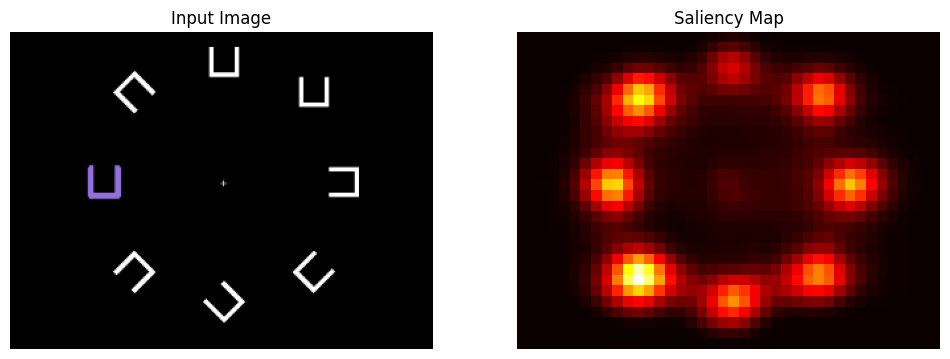

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


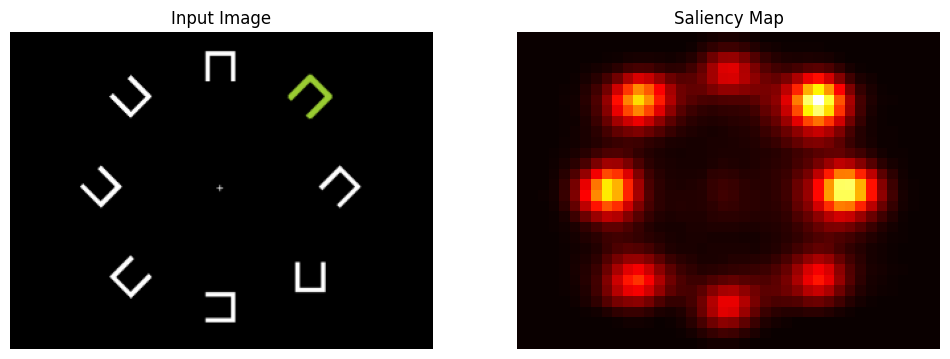

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


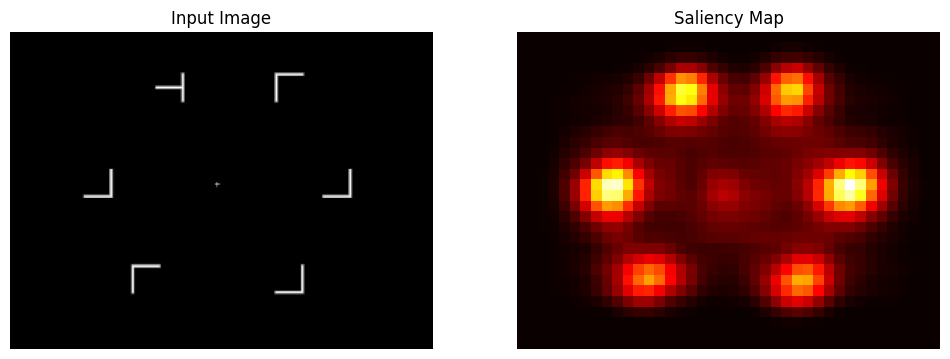

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


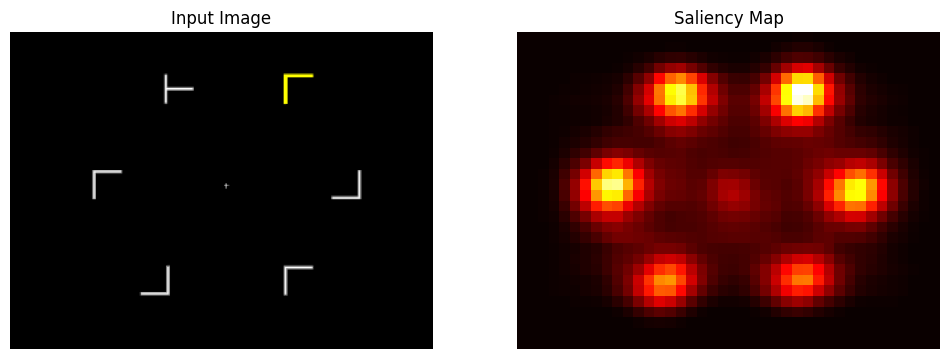

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


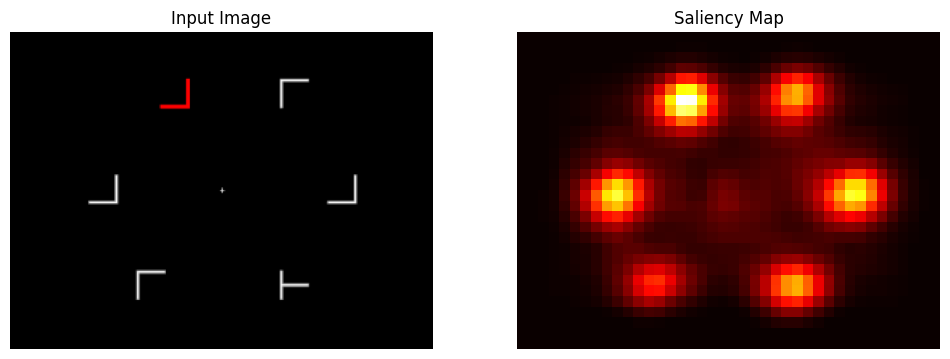

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


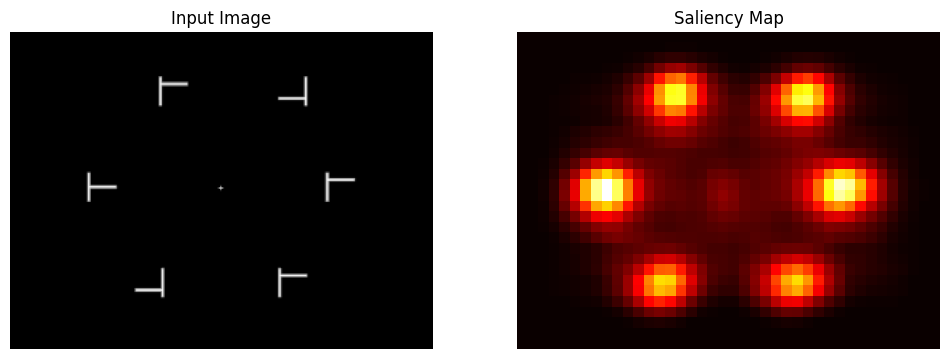

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


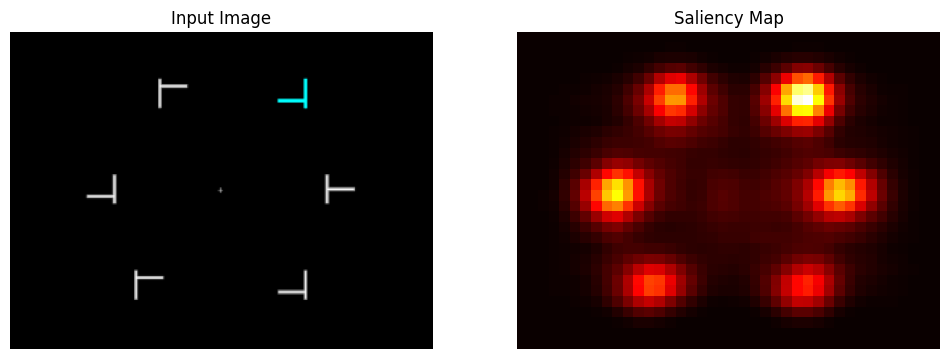

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


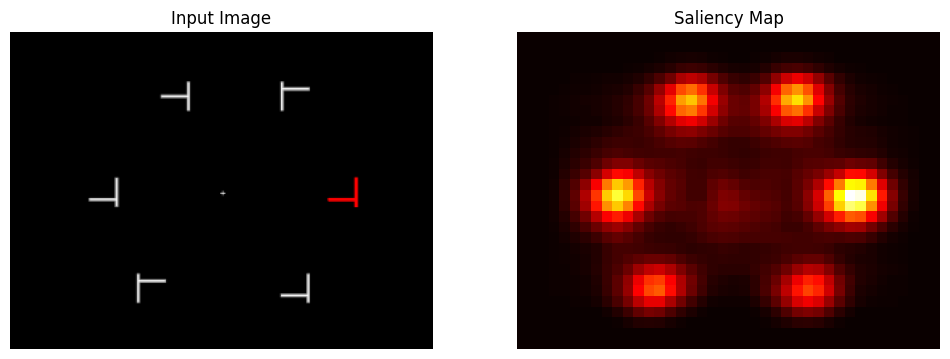

In [ ]:
# Image path
ip0 = "/content/drive/MyDrive/BU/Exp_image/Rand-C1.png"
ip1 = "/content/drive/MyDrive/BU/Exp_image/Rand-C2.png"
ip2 = "/content/drive/MyDrive/BU/Exp_image/TL1.png"
ip3 = "/content/drive/MyDrive/BU/Exp_image/TL2.png"
ip4 = "/content/drive/MyDrive/BU/Exp_image/TL3.png"
ip5 = "/content/drive/MyDrive/BU/Exp_image/oTL1.png"
ip6 = "/content/drive/MyDrive/BU/Exp_image/oTL2.png"
ip7 = "/content/drive/MyDrive/BU/Exp_image/oTL3.png"


im_list1 = [ip0,ip1,ip2,ip3,ip4,ip5,ip6,ip7]
for image_path in im_list1:
    input_image = preprocess_image(image_path)
    conv3_pool, conv4_pool, conv5_3 = mlnet.predict(input_image)
    saliency_map = compute_final_output(conv3_pool, conv4_pool, conv5_3, shape_r_gt, shape_c_gt)
    visualize_output(input_image, saliency_map)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


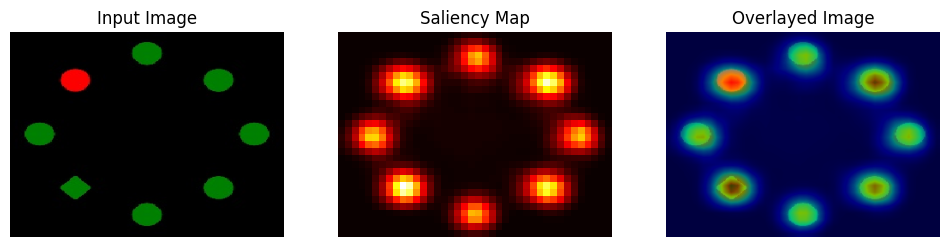

In [17]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, Concatenate, Dropout
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt


# Paths to saved model and weights
model_path = "/content/drive/MyDrive/BU/saved_model2/ml_net_model2.h5"
int_conv_path = '/content/drive/MyDrive/BU/saved_model2/int_conv.weights.h5'
pre_final_conv_path = '/content/drive/MyDrive/BU/saved_model2/pre_final_conv.weights.h5'
prior_path = '/content/drive/MyDrive/BU/saved_model2/prior_weights.npy'


# Load model
mlnet = load_model(model_path, compile=False)


prior = tf.Variable(
    initial_value=np.load(prior_path),
    trainable=False,
    name="prior",
    dtype=tf.float32,
)


pre_final_conv_layer = Conv2D(
    filters=1,
    kernel_size=(1, 1),
    activation="relu",
    kernel_initializer="glorot_normal",
    name="pre_final_conv"
)
pre_final_conv_model = tf.keras.Sequential([pre_final_conv_layer])
pre_final_conv_model.build(input_shape=(None, 30, 40, 64))
pre_final_conv_model.load_weights(pre_final_conv_path)


int_conv_layer = Conv2D(
    filters=64,
    kernel_size=(3, 3),
    activation='relu',
    padding='same',
    kernel_initializer='glorot_normal',
    name="int_conv"
)
int_conv_model = tf.keras.Sequential([int_conv_layer])
int_conv_model.build(input_shape=(None, 30, 40, 1280))
int_conv_model.load_weights(int_conv_path)

shape_r_gt, shape_c_gt = 30, 40


image_path = '/content/drive/MyDrive/Exp/pre/size8/img9.jpg'
#ground_truth_path = "/content/drive/MyDrive/BU/preprocessed_images/train_maps/COCO_train2014_000000000419.png"

# Load and preprocess image
def preprocess_image(image_path, target_size=(240, 320)):
    """
    Load and preprocess an image for the model.
    """
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
    return np.expand_dims(img_array, axis=0)  # Add batch dimension

# Load and preprocess ground truth
def preprocess_ground_truth(gt_path, target_size=(30, 40)):
    """
    Load and preprocess a ground truth saliency map.
    """
    gt = load_img(gt_path, color_mode="grayscale", target_size=target_size)
    gt_array = img_to_array(gt) / 255.0  # Normalize to [0, 1]
    return gt_array


# Compute final output (saliency map)
def compute_final_output(conv3_pool, conv4_pool, conv5_3, shape_r_gt, shape_c_gt):

    concatenated = Concatenate(axis=-1)([conv3_pool, conv4_pool, conv5_3])
    dropout_output = Dropout(0.5)(concatenated)
    int_conv_output = int_conv_model(dropout_output)
    pre_final_conv_output = pre_final_conv_model(int_conv_output)
    prior_upsampled = tf.image.resize(prior, [shape_r_gt, shape_c_gt])
    saliency_map = tf.keras.layers.Multiply()([pre_final_conv_output, prior_upsampled])
    return saliency_map


# Overlay Saliency Map on Input Image
def overlay_saliency_map(input_image, saliency_map, alpha=0.5):

    # Remove batch dimension and normalize saliency map
    input_image = input_image[0]  # Shape: (height, width, 3)
    saliency_map = tf.squeeze(saliency_map)  # Remove batch and channel dimensions
    saliency_map = tf.image.resize(saliency_map[..., tf.newaxis], input_image.shape[:2])  # Resize to match input image
    saliency_map = tf.squeeze(saliency_map).numpy()  # Convert to numpy for overlaying
    saliency_map = (saliency_map - np.min(saliency_map)) / (np.max(saliency_map) - np.min(saliency_map))  # Normalize to [0, 1]

    # Overlay saliency map on input image
    overlay = input_image * (1 - alpha) + plt.cm.jet(saliency_map)[..., :3] * alpha  # Use 'jet' colormap
    return np.clip(overlay, 0, 1)  # Ensure values are within [0, 1]


# Visualize the overlay
def visualize_results_with_overlay(image, saliency_map):
    """
    Visualizes the input image, saliency map, overlayed image, and ground truth.
    """
    # Generate overlayed image
    overlayed_image = overlay_saliency_map(image, saliency_map)

    plt.figure(figsize=(12, 6))

    # Input image
    plt.subplot(1, 3, 1)
    plt.imshow(image[0])  # Remove batch dimension
    plt.title("Input Image")
    plt.axis("off")

    # Saliency map
    plt.subplot(1, 3, 2)
    plt.imshow(tf.squeeze(saliency_map), cmap='hot')  # Remove batch and channel dimensions
    plt.title("Saliency Map")
    plt.axis("off")

    # Overlayed image
    plt.subplot(1, 3, 3)
    plt.imshow(overlayed_image)
    plt.title("Overlayed Image")
    plt.axis("off")


    plt.show()


# Preprocess and visualize
input_image = preprocess_image(image_path)

conv3_pool, conv4_pool, conv5_3 = mlnet.predict(input_image)
saliency_map = compute_final_output(conv3_pool, conv4_pool, conv5_3, shape_r_gt, shape_c_gt)

visualize_results_with_overlay(input_image, saliency_map)
